Fitting of MFX-confocal shift compensation for the recorded shift files in a folder. Bidirectional or unidirectional scanning is handled.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import os
import skimage.feature as ft
from scipy.optimize import curve_fit
from scipy import stats, signal

def gaussian2D(xy, amplitude, xo, yo, sigma, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma**2) + (np.sin(theta)**2)/(2*sigma**2)
    b = -(np.sin(2*theta))/(4*sigma**2) + (np.sin(2*theta))/(4*sigma**2)
    c = (np.sin(theta)**2)/(2*sigma**2) + (np.cos(theta)**2)/(2*sigma**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def sinusoidal(x, a, x0, f, b, c):
    y = a*np.sin(2*np.pi*f*x+x0) + b - x/c
    return (y)

def secpol(x, a, b, c):
    y = a*x**2 + b*x + c
    return (y)

def linear(x, a, b):
    y = a*x + b
    return (y)

def distance(p_1, p_2):
    return np.sqrt((p_2[0]-p_1[0])**2+(p_2[1]-p_1[1])**2)

parentdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [13]:
folder = os.path.join(parentdir, 'exampledata\\confshift\\pxs100fov80bid\\01')

filelist = os.listdir(folder)
filelist_tif = [file for file in filelist if file.endswith('.tif')]
print(filelist_tif)

saving = True

d_th_um = 0.35  # distance threshold for being considered the same bead
imgmini_size = 9
base_comp_idx = len(filelist_tif)-1

['confocal-pxs100nm-dwell002us-rep0.tif', 'confocal-pxs100nm-dwell002us-rep2.tif', 'confocal-pxs100nm-dwell002us-rep3.tif', 'confocal-pxs100nm-dwell002us-rep4.tif', 'confocal-pxs100nm-dwell002us-rep5.tif', 'confocal-pxs100nm-dwell100us-rep0.tif']


In [14]:
x_pks_corr_all = []
y_pks_corr_all = []
scanspeeds = []
pxsizes = []
pxsizesscaled = []
dwelltimes = []
for path_idx in range(len(filelist_tif)):
    print(filelist_tif[path_idx])
    pxsize = int(filelist_tif[path_idx].split('pxs')[1].split('nm')[0])/1000  # pixel size in µm
    dwelltime = int(filelist_tif[path_idx].split('dwell')[1].split('us')[0])/1000  # dwell time in ms
    if 'scaled' in filelist_tif[path_idx]:
        pxsscaled = int(filelist_tif[path_idx].split('scaled')[1].split('.')[0])/1000  # pixel size, scaled, in µm
    else:
        pxsscaled = pxsize
    pxsizesscaled.append(pxsscaled)
    pxsizes.append(pxsize)
    speed = pxsize/dwelltime  # scan speed in µm/ms
    scanspeeds.append(speed)
    dwelltimes.append(dwelltime)  # dwell time in ms
    print(f'Scan speed: {speed:.1f} µm/ms')
    img = tiff.imread(os.path.join(folder,filelist_tif[path_idx]))-32768
    img_max = np.max(img)
    pk_th_hi = img_max*0.6
    pk_th_lo = np.max([6,img_max*0.08])
    print(pk_th_lo)
    pks = ft.peak_local_max(img, min_distance=int(0.21/pxsscaled), threshold_abs=pk_th_lo)
    x_pks = pks[:,1]
    y_pks = pks[:,0]

    x_pks_filt = []
    y_pks_filt = []
    for pkx,pky in zip(x_pks[:],y_pks[:]):
        if img[pky,pkx] < pk_th_hi:
            x_pks_filt.append(pkx)
            y_pks_filt.append(pky)

    imgmini_rad = int((imgmini_size-1)/2)
    dxs = []
    dys = []

    for pkx,pky in zip(x_pks_filt,y_pks_filt):
        img_mini = img[pky-imgmini_rad:pky+imgmini_rad+1, pkx-imgmini_rad:pkx+imgmini_rad+1]
        # fit symmetric 2D gaussian
        x = np.linspace(0, imgmini_size-1, imgmini_size)
        y = np.linspace(0, imgmini_size-1, imgmini_size)
        x, y = np.meshgrid(x, y)
        try:
            initial_guess = (np.max(img_mini),imgmini_rad,imgmini_rad,1,0,10)
            popt, _ = curve_fit(gaussian2D, (x, y), img_mini.ravel(), p0=initial_guess)
            # get offsets from pixel-position
            dx = popt[1]-imgmini_rad
            dy = popt[2]-imgmini_rad
            dxs.append(dx)
            dys.append(dy)
        except:
            dxs.append(np.nan)
            dys.append(np.nan)
    x_pks_corr = [x_pk+dx for x_pk,dx in zip(x_pks_filt,dxs)]
    y_pks_corr = [y_pk+dx for y_pk,dx in zip(y_pks_filt,dys)]
    x_pks_corr_all.append(x_pks_corr)
    y_pks_corr_all.append(y_pks_corr)
    print(len(x_pks_corr))

x_pks_base = x_pks_corr_all[base_comp_idx]
y_pks_base = y_pks_corr_all[base_comp_idx]
bead_links = [[] for _ in x_pks_base]  # each row has the bead indexes of the beads in each image which belongs together

for idx_base, (x_pk,y_pk) in enumerate(zip(x_pks_base,y_pks_base)):
    for comp_idx in np.delete(np.linspace(0,len(filelist_tif)-1,len(filelist_tif), dtype=int), base_comp_idx):
        d_th = int(d_th_um/pxsizesscaled[comp_idx])
        d_min = d_th
        idx_min = np.nan
        for idx_c, (x_pk_c, y_pk_c) in enumerate(zip(x_pks_corr_all[comp_idx],y_pks_corr_all[comp_idx])):
            d = distance((x_pk,y_pk),(x_pk_c,y_pk_c))
            if d < d_min:
                d_min = d
                idx_min = idx_c
                bead_links[idx_base].append(idx_min)
                break
        if d_min == d_th:
            bead_links[idx_base].append(np.nan)
    bead_links[idx_base].insert(base_comp_idx, idx_base)

rm_idx = []
for idx, link in enumerate(bead_links):
    if np.any(np.isnan(link)):
        rm_idx.append(idx)

for index in sorted(rm_idx, reverse=True):
    del bead_links[index]

print(len(bead_links))

x_shifts = [[] for _ in x_pks_corr_all]
x_pos = [[] for _ in x_pks_corr_all]
for bead_ids in bead_links:
    x_shifts[base_comp_idx].append(0)
    for img_id in np.delete(np.linspace(0,len(filelist_tif)-1,len(filelist_tif), dtype=int), base_comp_idx):
        x_shift = (x_pks_corr_all[base_comp_idx][bead_ids[base_comp_idx]] - x_pks_corr_all[img_id][bead_ids[img_id]])*pxsizesscaled[img_id]
        x_shifts[img_id].append(x_shift)
        x_pos[img_id].append(x_pks_corr_all[img_id][bead_ids[img_id]]*pxsizesscaled[img_id])

y_shifts = [[] for _ in y_pks_corr_all]
y_pos = [[] for _ in y_pks_corr_all]
for bead_ids in bead_links:
    y_shifts[base_comp_idx].append(0)
    for img_id in np.delete(np.linspace(0,len(filelist_tif)-1,len(filelist_tif), dtype=int), base_comp_idx):
        y_shift = (y_pks_corr_all[base_comp_idx][bead_ids[base_comp_idx]] - y_pks_corr_all[img_id][bead_ids[img_id]])*pxsizesscaled[img_id]
        y_shifts[img_id].append(y_shift)
        y_pos[img_id].append(y_pks_corr_all[img_id][bead_ids[img_id]]*pxsizesscaled[img_id])

confocal-pxs100nm-dwell002us-rep0.tif
Scan speed: 50.0 µm/ms
6.0
2108
confocal-pxs100nm-dwell002us-rep2.tif
Scan speed: 50.0 µm/ms
6.0
2087
confocal-pxs100nm-dwell002us-rep3.tif
Scan speed: 50.0 µm/ms
6.0
2080
confocal-pxs100nm-dwell002us-rep4.tif
Scan speed: 50.0 µm/ms
6.0
2073
confocal-pxs100nm-dwell002us-rep5.tif
Scan speed: 50.0 µm/ms
6.0
2088
confocal-pxs100nm-dwell100us-rep0.tif
Scan speed: 1.0 µm/ms
200.8
2059
1784


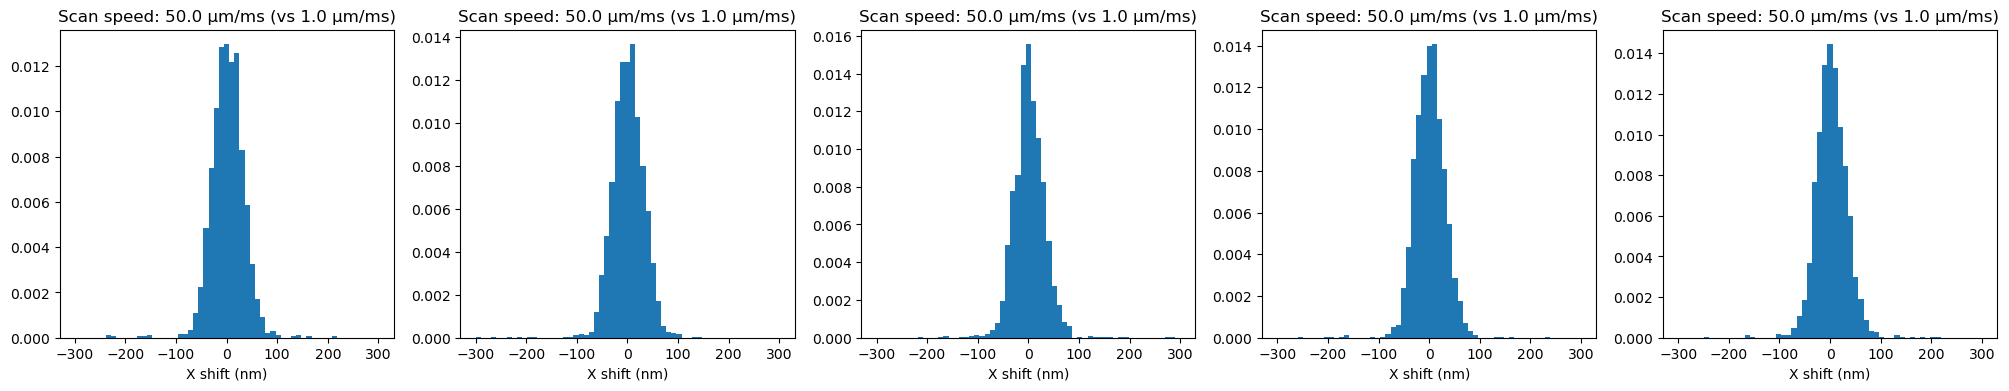

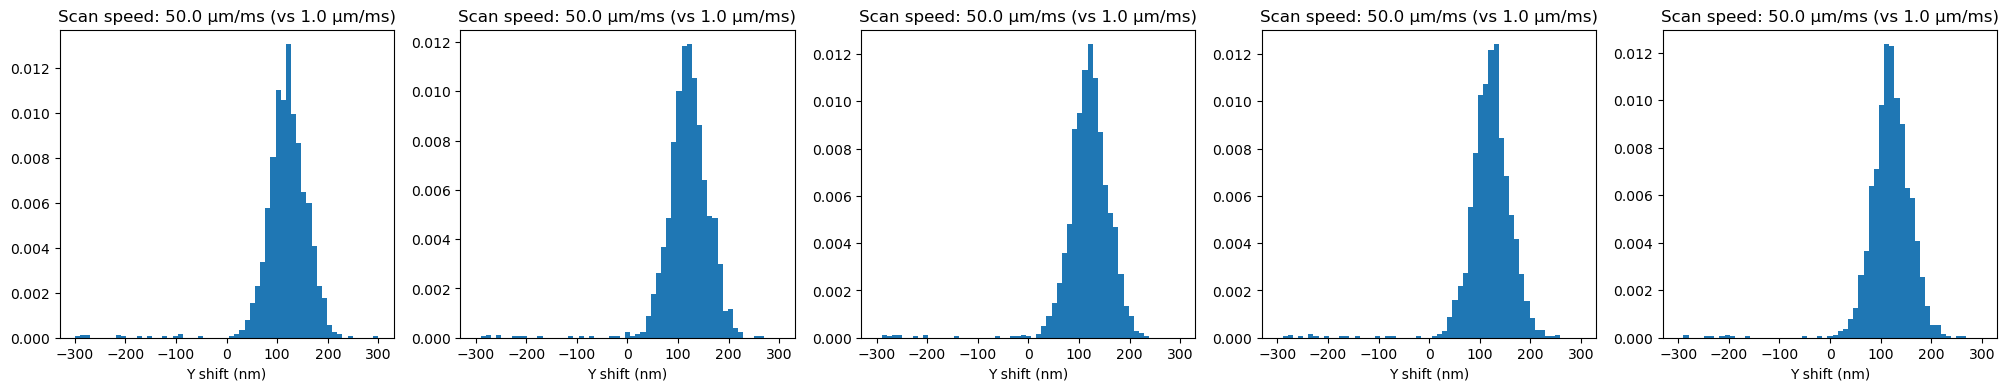

In [15]:
# PLOT X AND Y SHIFT DISTRIBUTIONS FOR EACH IMAGE
fig,ax = plt.subplots(1,len(filelist_tif)-1,figsize=(5*(len(filelist_tif)-1),4))
plotid = 0
for img_id in np.delete(np.linspace(0,len(filelist_tif)-1,len(filelist_tif), dtype=int), base_comp_idx):
    ax[plotid].hist(np.array(x_shifts[img_id])*1000, bins=np.linspace(-300,300,60), density=True);
    ax[plotid].set_xlabel('X shift (nm)')
    ax[plotid].set_title(f'Scan speed: {scanspeeds[img_id]:.1f} µm/ms (vs {scanspeeds[base_comp_idx]:.1f} µm/ms)')
    plotid += 1

fig,ax = plt.subplots(1,len(filelist_tif)-1,figsize=(5*(len(filelist_tif)-1),4))
plotid = 0
for img_id in np.delete(np.linspace(0,len(filelist_tif)-1,len(filelist_tif), dtype=int), base_comp_idx):
    ax[plotid].hist(np.array(y_shifts[img_id])*1000, bins=np.linspace(-300,300,60), density=True);
    ax[plotid].set_xlabel('Y shift (nm)')
    ax[plotid].set_title(f'Scan speed: {scanspeeds[img_id]:.1f} µm/ms (vs {scanspeeds[base_comp_idx]:.1f} µm/ms)')
    plotid += 1

PLOT X AND Y SHIFTS FOR ALL DIFFERENT IMAGES

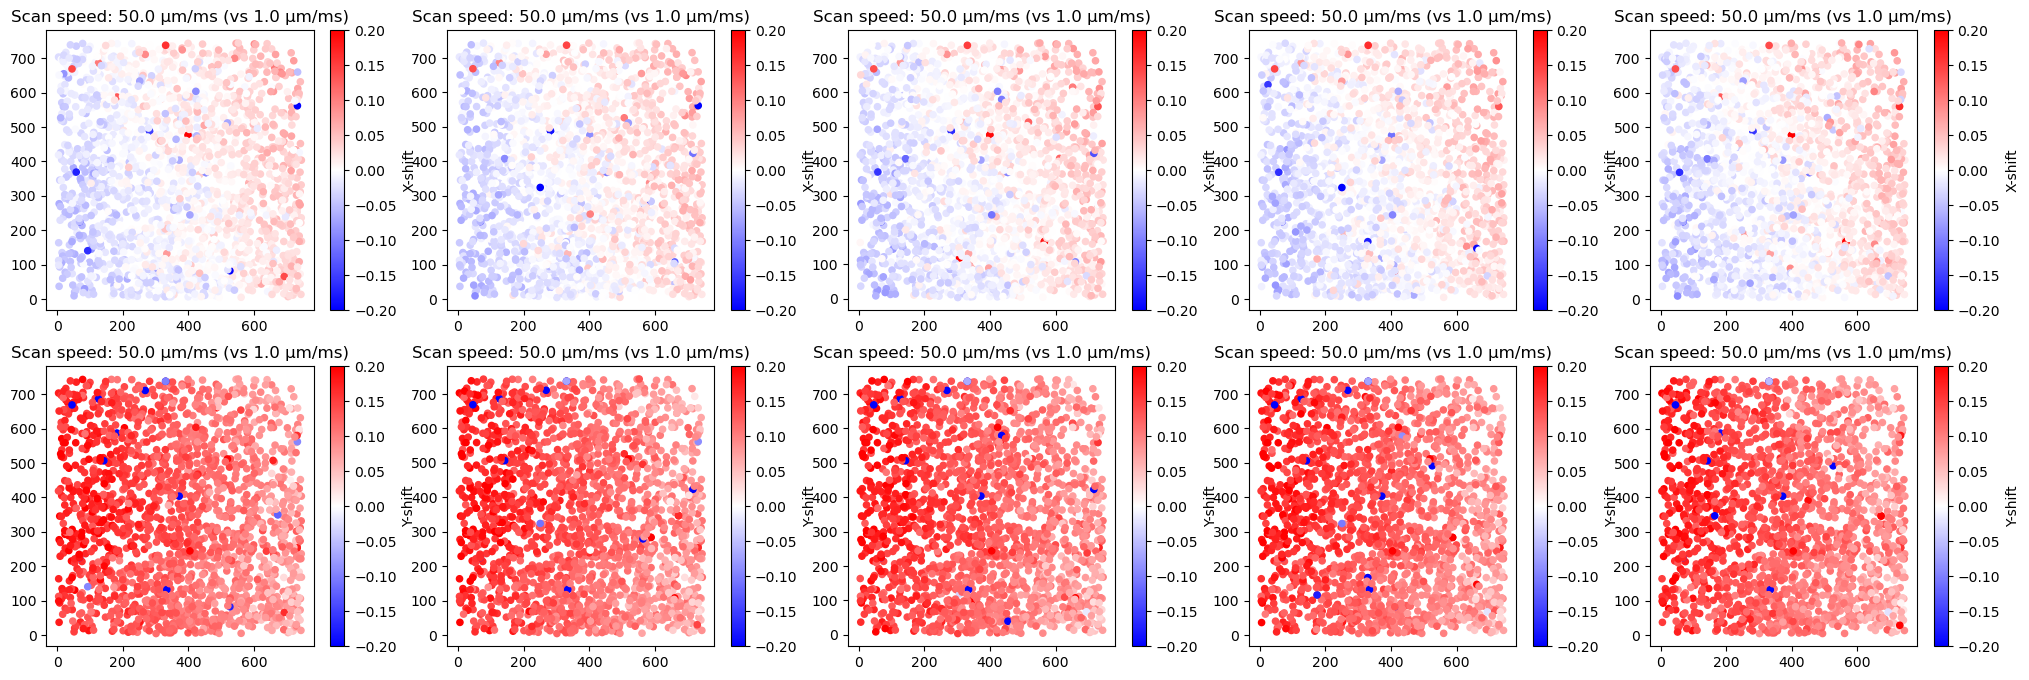

In [16]:
bead_links_np = np.array(bead_links)

fig,ax = plt.subplots(2,len(filelist_tif)-1,figsize=(5*(len(filelist_tif)-1),8))
plotid = 0
for img_id in np.delete(np.linspace(0,len(filelist_tif)-1,len(filelist_tif), dtype=int), base_comp_idx):
    scx = ax[0,plotid].scatter(np.array(x_pks_corr_all[img_id])[bead_links_np[:,img_id]], np.array(y_pks_corr_all[img_id])[bead_links_np[:,img_id]], s=20, c=x_shifts[img_id], cmap='bwr', vmin=-0.2, vmax=0.2)
    scy = ax[1,plotid].scatter(np.array(x_pks_corr_all[img_id])[bead_links_np[:,img_id]], np.array(y_pks_corr_all[img_id])[bead_links_np[:,img_id]], s=20, c=y_shifts[img_id], cmap='bwr', vmin=-0.2, vmax=0.2)
    plt.colorbar(scx, label='X-shift')
    plt.colorbar(scy, label='Y-shift')
    ax[0,plotid].set_title(f'Scan speed: {scanspeeds[img_id]:.1f} µm/ms (vs {scanspeeds[base_comp_idx]:.1f} µm/ms)')
    ax[1,plotid].set_title(f'Scan speed: {scanspeeds[img_id]:.1f} µm/ms (vs {scanspeeds[base_comp_idx]:.1f} µm/ms)')
    plotid += 1
plt.show()

FIT X SHIFT


Scan speed: 50.0 µm/ms

Scan speed: 50.0 µm/ms

Scan speed: 50.0 µm/ms

Scan speed: 50.0 µm/ms

Scan speed: 50.0 µm/ms


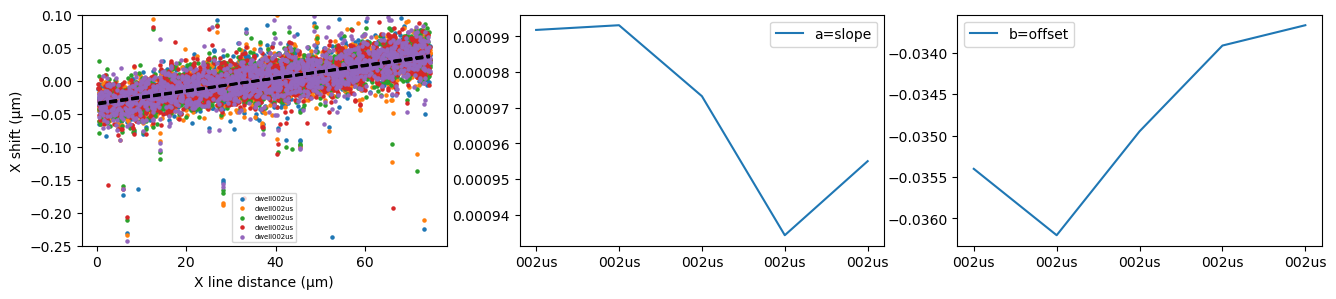

In [17]:
t_lim = 0.1  # 100 µs ~ 7 µm with 70 nm pxs and 1 µs dwell, seems to be the affected area of the initial ramping
img_ids = np.delete(np.linspace(0,len(filelist_tif)-1,len(filelist_tif), dtype=int), base_comp_idx)

popts = []
popts2 = []
labels = []
labels2 = []
x_fit = np.linspace(np.min(x_pos[2]), np.max(x_pos[2]), 100)
if 'bid' in folder:
    x_use_all = []
    x_shift_use_all = []
else:
    x1_use_all = []
    x1_shift_use_all = []
    x2_use_all = []
    x2_shift_use_all = []
x_all = []
x_shift_all = []

fig, axs = plt.subplots(1, 3, figsize=(16,3))

for img_id in img_ids:
    if img_id != base_comp_idx:
        print('')
        print(f'Scan speed: {scanspeeds[img_id]:.1f} µm/ms')
        x = np.array(x_pos[img_id])
        x_shift = np.array(x_shifts[img_id])
        y_shift = np.array(y_shifts[img_id])
        axs[0].scatter(x, x_shift, s=5, label=filelist_tif[img_id].split('-')[2].split('.')[0])
        x_all.append(x)
        x_shift_all.append(x_shift)

        # remove outliers
        x_shift_sm = signal.savgol_filter(x_shift, int(len(x_shift)/3), 3)
        zs = stats.zscore(x_shift_sm - x_shift)
        mask = np.abs(zs) < 2.3

        if 'bid' in folder:
            # FIT LINEAR FUNCTION
            # remove points from initial ramping phase
            x_use = x[mask]
            x_shift_use = x_shift[mask]
            x_use_all.append(x_use)
            x_shift_use_all.append(x_shift_use)

            p0 = [1, 1]  # initial guess
            #bounds: a=slope, b=offset
            bounds = [(-10, -30), (10, 30)]
            try:
                popt, pcov = curve_fit(linear, x_use, x_shift_use, p0, bounds=bounds, method='dogbox', maxfev=3000)
                shift_fit = linear(x_fit, *popt)
                popts.append(popt)
                labels.append(filelist_tif[img_id].split('-')[2].split('.')[0].split('dwell')[1])
                axs[0].plot(x_fit, shift_fit, 'k--')
            except:
                pass
        else:
            # FIT MAIN SIGMOID
            # remove points from initial ramping phase
            x_lim = scanspeeds[img_id]*t_lim
            print(f'Initial acceleration length: {x_lim:.1f} µm')
            mask[x < x_lim] = False
            x_use = x[mask]
            x_shift_use = x_shift[mask]
            x1_use_all.append(x_use)
            x1_shift_use_all.append(x_shift_use)
            
            # sigmoid fit
            p0 = [(max(x_shift_use)-min(x_shift_use))/2, x_lim*2, 0.1, min(x_shift_use)]  # initial guess
            #bounds: L=asymptote difference, x0=point of inflection, k=slope, b=low asymptote
            bounds = [(0, x_lim*2/3 if x_lim>0.4 else 0, 0, -0.3), (0.6, 20, 3, 0.1)]
            try:
                popt, pcov = curve_fit(sigmoid, x_use, x_shift_use, p0, bounds=bounds, method='dogbox', maxfev=3000)
                shift_fit = sigmoid(x_fit, *popt)
                popt = np.append(popt,popt[-1]+popt[0])
                popts.append(popt)
                labels.append(filelist_tif[img_id].split('-')[2].split('.')[0].split('dwell')[1])
                scanlag = (-(popt[-2]+popt[0])/scanspeeds[img_id])*1000  # scanlag, time, in ms
                print(f'Measured asymptote scan lag: {scanlag:.2f} ms')
                #axs[0].plot(x_fit, shift_fit, 'k--')
            except:
                pass
            
            # FIT INITIAL SECOND DEGREE POLYNOMIAL
            # remove outliers
            x_shift_sm = signal.savgol_filter(x_shift, int(len(x_shift)/3), 3)
            zs = stats.zscore(x_shift_sm - x_shift)
            mask = np.abs(zs) < 2.3
            # remove points from initial ramping phase
            x_lim = scanspeeds[img_id]*t_lim
            mask[x > x_lim] = False
            x_use = x[mask]
            x_shift_use = x_shift[mask]
            x2_use_all.append(x_use)
            x2_shift_use_all.append(x_shift_use)
            
            if len(x_shift_use) > 10:
                # sec. deg. poly. fit
                p0 = [0.002, -0.02, -0.1]
                bounds = [(0.0001, -0.05, -0.15), (0.005, -0.005, -0.02)]
                try:
                    popt2, pcov = curve_fit(secpol, x_use, x_shift_use, p0, bounds=bounds, method='dogbox', maxfev=3000)
                    shift_fit = secpol(x_fit, *popt2)
                    popts2.append(popt2)
                    labels2.append(filelist_tif[img_id].split('-')[2].split('.')[0].split('dwell')[1])
                    combfunc_fit = (1-sigmoid(x_fit, *[1,x_lim,1,0]))*secpol(x_fit, *popt2) + sigmoid(x_fit, *[1,x_lim,1,0])*sigmoid(x_fit, *popt[:-1])
                    axs[0].plot(x_fit, combfunc_fit, 'k--')
                except:
                    pass
                # COMBINE FITS
            else:
                combfunc_fit = sigmoid(x_fit, *popt[:-1])
                axs[0].plot(x_fit, combfunc_fit, 'k--')
if 'bid' in folder:
    x_shift_use_all = np.concatenate(x_shift_use_all).ravel()
    x_use_all = np.concatenate(x_use_all).ravel()
else:
    x1_shift_use_all = np.concatenate(x1_shift_use_all).ravel()
    x2_shift_use_all = np.concatenate(x2_shift_use_all).ravel()
    x1_use_all = np.concatenate(x1_use_all).ravel()
    x2_use_all = np.concatenate(x2_use_all).ravel()
x_all = np.concatenate(x_all).ravel()
x_shift_all = np.concatenate(x_shift_all).ravel()

axs[0].set_ylim([-0.25,0.1])
axs[0].legend(prop={'size': 5})
axs[0].set_xlabel('X line distance (µm)')
axs[0].set_ylabel('X shift (µm)')

popts = np.array(popts)
if 'bid' in folder:
    for i in [0]:
        axs[1].plot(popts[:,i])
    axs[1].legend(['a=slope'])
    axs[1].set_xticks(np.linspace(0,len(labels)-1,len(labels)));
    axs[1].set_xticklabels(labels);

    for i in [1]:
        axs[2].plot(popts[:,i])
    axs[2].legend(['b=offset'])
    axs[2].set_xticks(np.linspace(0,len(labels)-1,len(labels)));
    axs[2].set_xticklabels(labels);
else:
    for i in [0,2,3,4]:
        axs[1].plot(popts[:,i])
    axs[1].legend(['L=asympt diff', 'k=slope', 'b=low asympt', 'a=high asympt'])
    axs[1].set_xticks(np.linspace(0,len(labels)-1,len(labels)));
    axs[1].set_xticklabels(labels);

    for i in [1]:
        axs[2].plot(popts[:,i])
    axs[2].legend(['x0=point of inflection'])
    axs[2].set_xticks(np.linspace(0,len(labels)-1,len(labels)));
    axs[2].set_xticklabels(labels);

plt.show()

if saving:
    # save fit parameters
    if 'bid' in folder:
        savename = 'linearfitting-xshift'
        with open(os.path.join(folder,savename+'.txt'), 'w') as f:
            for line in popts:
                f.write(f"{line}\n")
    else:
        savename = 'sigmoidfitting-xshift'
        with open(os.path.join(folder,savename+'.txt'), 'w') as f:
            for line in popts:
                f.write(f"{line}\n")

        savename = 'quadraticfitting-xshift'
        with open(os.path.join(folder,savename+'.txt'), 'w') as f:
            for line in popts2:
                f.write(f"{line}\n")

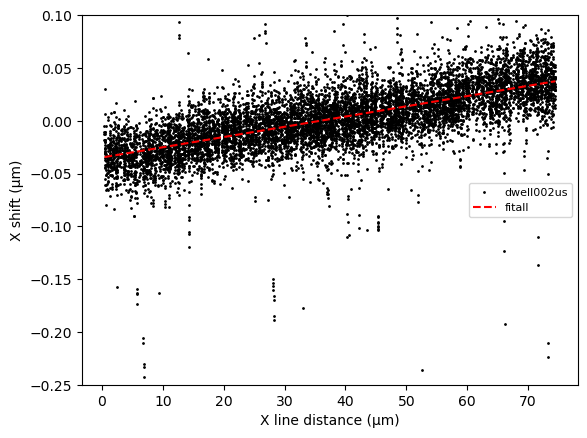

In [18]:
### FIT ALL DATAPOINTS IN ONE FIT - IF ALL LINES AGREE SOMEWHAT

if 'bid' in folder:
    p0 = [1, 1]  # initial guess
    #bounds: a=slope, b=offset
    bounds = [(-10, -30), (10, 30)]
    popt, pcov = curve_fit(linear, x_use_all, x_shift_use_all, p0, bounds=bounds, method='dogbox', maxfev=3000)
    shift_fit = linear(x_fit, *popt)
    labels.append(filelist_tif[img_id].split('-')[2].split('.')[0].split('dwell')[1])
    axs[0].plot(x_fit, shift_fit, 'k--')

    linfunc_fit = linear(x_fit, *popt)

    plt.scatter(x_all, x_shift_all, s=1, color='k', label=filelist_tif[img_id].split('-')[2].split('.')[0])
    plt.plot(x_fit, linfunc_fit, 'r--', label='fitall')

    plt.ylim([-0.25,0.1])
    plt.legend(prop={'size': 8})
    plt.xlabel('X line distance (µm)')
    plt.ylabel('X shift (µm)')    
else:
    x_lim = scanspeeds[0]*t_lim

    # FIT ENDING SIGMOID
    p0 = [(max(x1_shift_use_all)-min(x1_shift_use_all))/2, x_lim*2, 0.1, min(x1_shift_use_all)]  # initial guess
    #bounds: L=asymptote difference, x0=point of inflection, k=slope, b=low asymptote
    bounds = [(0, x_lim*2/3 if x_lim>0.4 else 0, 0, -0.3), (0.6, 20, 3, 0.1)]
    popt, pcov = curve_fit(sigmoid, x1_use_all, x1_shift_use_all, p0, bounds=bounds, method='trf', maxfev=5000)
    shift_fit = sigmoid(x_fit, *popt)
    popt = np.append(popt,popt[-1]+popt[0])
    labels.append(filelist_tif[0].split('-')[2].split('.')[0].split('dwell')[1])

    # FIT INITIAL SECOND DEGREE POLYNOMIAL
    p0 = [0.002, -0.02, -0.1]
    bounds = [(0.0001, -0.05, -0.15), (0.005, -0.005, -0.02)]
    popt2, pcov = curve_fit(secpol, x2_use_all, x2_shift_use_all, p0, bounds=bounds, method='trf', maxfev=5000)
    shift_fit = secpol(x_fit, *popt2)
    labels2.append(filelist_tif[img_id].split('-')[2].split('.')[0].split('dwell')[1])

    combfunc_fit = (1-sigmoid(x_fit, *[1,x_lim,1,0]))*secpol(x_fit, *popt2) + sigmoid(x_fit, *[1,x_lim,1,0])*sigmoid(x_fit, *popt[:-1])

    plt.scatter(x_all, x_shift_all, s=1, color='k', label=filelist_tif[img_id].split('-')[2].split('.')[0])
    plt.plot(x_fit, combfunc_fit, 'r--', label='fitall')

    # FOR PXS 70 NM
    if pxsizes[0]*1000 == 70.0:
        if 'bid' in folder:
            fitfile = 'C:\\Users\\alvelidjonatan\\Documents\\Data\\etMINFLUX-lab\\beads-overlay\\confshift\\final_fits\\multifitting-xshift-pxs70-bid80.txt'
        else:
            fitfile = 'C:\\Users\\alvelidjonatan\\Documents\\Data\\etMINFLUX-lab\\beads-overlay\\confshift\\final_fits\\multifitting-xshift-pxs70-80.txt'
            x_limfit = 3.5
    elif  pxsizes[0]*1000 == 100.0:
        if 'bid' in folder:
            fitfile = 'C:\\Users\\alvelidjonatan\\Documents\\Data\\etMINFLUX-lab\\beads-overlay\\confshift\\final_fits\\multifitting-xshift-pxs100-bid80.txt'
    # FOR PXS 60 NM
    elif pxsizes[0]*1000 == 60.0:
        fitfile = 'C:\\Users\\alvelidjonatan\\Documents\\Data\\etMINFLUX-lab\\beads-overlay\\confshift\\final_fits\\multifitting-xshift-pxs60-40.txt'
        x_limfit = 6.0
    
    with open(fitfile, 'r') as f:
        content = f.read()
    coeffs = [float(i) for i in content.split('\n') if i != '']
    if 'bid' in folder:
        coeffs_lin = coeffs
        combfunc_fit = linear(x_fit, *coeffs_lin)
    else:
        coeffs_sigmoid = coeffs[:4]
        coeffs_quad = coeffs[4:]
        combfunc_fit = (1-sigmoid(x_fit, *[1,x_limfit,1,0]))*secpol(x_fit, *coeffs_quad) + sigmoid(x_fit, *[1,x_limfit,1,0])*sigmoid(x_fit, *coeffs_sigmoid)
    plt.plot(x_fit, combfunc_fit, 'b--', label='multifit')
    plt.ylim([-0.25,0.1])
    plt.legend(prop={'size': 8})
    plt.xlabel('X line distance (µm)')
    plt.ylabel('X shift (µm)')

if saving:
    savename = 'multiimagefitting-xshift'
    if 'bid'in folder:
        with open(os.path.join(folder,savename+'.txt'), 'w') as f:
            for line in popt:
                f.write(f"{line}\n")
    else:
        with open(os.path.join(folder,savename+'.txt'), 'w') as f:
            for line in popt[:-1]:
                f.write(f"{line}\n")
            f.write('\n')
            for line in popt2:
                f.write(f"{line}\n")

    savename = 'confshift-xshift-multiimagefitting'
    plt.savefig(os.path.join(folder,savename+'.png'), format="png", bbox_inches="tight")

FIT Y SHIFT

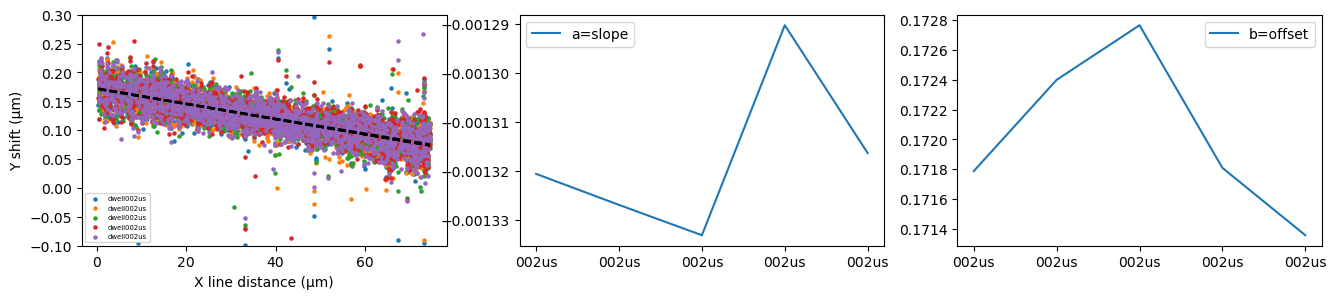

In [19]:
t_lim = 0.1  # 100 µs ~ 7 µm with 70 nm pxs and 1 µs dwell, seems to be the affected area of the initial ramping
img_ids = np.delete(np.linspace(0,len(filelist_tif)-1,len(filelist_tif), dtype=int), base_comp_idx)

popts_y = []
labels_y = []
x_fit = np.linspace(np.min(x_pos[2]), np.max(x_pos[2]), 100)

x_all = []
y_shift_all = []
x_use_all = []
y_shift_use_all = []

fig, axs = plt.subplots(1, 3, figsize=(16,3))

for img_id in img_ids[:]:
    if img_id != base_comp_idx:
        x = np.array(x_pos[img_id])
        y_shift = np.array(y_shifts[img_id])
        axs[0].scatter(x, y_shift, s=5, label=filelist_tif[img_id].split('-')[2].split('.')[0])
        x_all.append(x)
        y_shift_all.append(y_shift)

        # remove outliers
        y_shift_sm = signal.savgol_filter(y_shift, int(len(y_shift)/3), 3)
        zs = stats.zscore(y_shift_sm - y_shift)
        mask = np.abs(zs) < 2.3
        x_use = x[mask]
        y_shift_use = y_shift[mask]
        x_use_all.append(x_use)
        y_shift_use_all.append(y_shift_use)

        
        if 'bid' in folder:
            # FIT LINEAR FUNCTION
            p0 = [1, 1]  # initial guess
            #bounds: a=slope, b=offset
            bounds = [(-10, -30), (10, 30)]
            try:
                popt, pcov = curve_fit(linear, x_use, y_shift_use, p0, bounds=bounds, method='dogbox', maxfev=3000)
                shift_fit = linear(x_fit, *popt)
                popts_y.append(popt)
                labels_y.append(filelist_tif[img_id].split('-')[2].split('.')[0].split('dwell')[1])
                axs[0].plot(x_fit, shift_fit, 'k--')
            except:
                pass
        else:
            if pxsizes[0]*1000 == 70.0:
                p0 = [(max(y_shift_use)-min(y_shift_use))/4, 10, 0.8/(0.3*scanspeeds[img_id]), 0.02, 4000]  # initial guess; spatial freq: know temporal frequency is ~0.3 ms^-1
                bounds = [(0, -20, 0.68/(0.3*scanspeeds[img_id]), 0.01, 2000), ((max(y_shift_use)-min(y_shift_use))/2*5, 20, 0.9/(0.3*scanspeeds[img_id]), 0.06, 6000)]
            elif pxsizes[0]*1000 == 60.0:
                p0 = [(max(y_shift_use)-min(y_shift_use))/4, 0, 0.8/(0.3*scanspeeds[img_id]), (max(y_shift_use)-(max(y_shift_use)-min(y_shift_use))/2)+0.01, 4000]  # initial guess; spatial freq: know temporal frequency is ~0.3 ms^-1
                bounds = [((max(y_shift_use)-min(y_shift_use))/15, -10, 0.68/(0.3*scanspeeds[img_id]), -0.06, 0), ((max(y_shift_use)-min(y_shift_use))/2, 10, 0.9/(0.3*scanspeeds[img_id]), 0.06, 6000)]
            elif pxsizes[0]*1000 == 100.0:
                p0 = [(max(y_shift_use)-min(y_shift_use))/4, 10, 0.8/(0.3*scanspeeds[img_id]), 0.02, 4000]  # initial guess; spatial freq: know temporal frequency is ~0.3 ms^-1
                bounds = [(0, -20, 0.68/(0.3*scanspeeds[img_id]), 0.01, 2000), ((max(y_shift_use)-min(y_shift_use))/2*5, 20, 0.9/(0.3*scanspeeds[img_id]), 0.06, 6000)]
            try:
                popt, pcov = curve_fit(sinusoidal, x_use, y_shift_use, p0, bounds=bounds, method='dogbox')
                shift_fit = sinusoidal(x_fit, *popt)
                popts_y.append(popt)
                labels_y.append(filelist_tif[img_id].split('-')[2].split('.')[0].split('dwell')[1])
                axs[0].plot(x_fit, shift_fit, 'k--')
            except:
                pass

y_shift_use_all = np.concatenate(y_shift_use_all).ravel()
x_use_all = np.concatenate(x_use_all).ravel()
y_shift_all = np.concatenate(y_shift_all).ravel()
x_all = np.concatenate(x_all).ravel()

axs[0].set_ylim([-0.1,0.3])
axs[0].legend(prop={'size': 5})
axs[0].set_xlabel('X line distance (µm)')
axs[0].set_ylabel('Y shift (µm)')

popts_y = np.array(popts_y)
if 'bid' in folder:
    for i in [0]:
        axs[1].plot(popts_y[:,i])
    axs[1].legend(['a=slope'])
    axs[1].set_xticks(np.linspace(0,len(labels_y)-1,len(labels_y)));
    axs[1].set_xticklabels(labels_y);

    for i in [1]:
        axs[2].plot(popts_y[:,i])
    axs[2].legend(['b=offset'])
    axs[2].set_xticks(np.linspace(0,len(labels_y)-1,len(labels_y)));
    axs[2].set_xticklabels(labels_y);
else:
    for i in [0,2,3]:
        axs[1].plot(popts_y[:,i])
    axs[1].legend(['a=amplitude', 'b=offset'])
    axs[1].set_xticks(np.linspace(0,len(labels_y)-1,len(labels_y)));
    axs[1].set_xticklabels(labels_y);
    axs[1].set_ylim([-0.05,0.1])

    for i in [1,2]:
        axs[2].plot(popts_y[:,i])
    axs[2].legend(['x0=phase', 'f=frequency (osc/µm)'])
    axs[2].set_xticks(np.linspace(0,len(labels_y)-1,len(labels_y)));
    axs[2].set_xticklabels(labels_y);
    #axs[2].set_ylim([7,12])

plt.show()

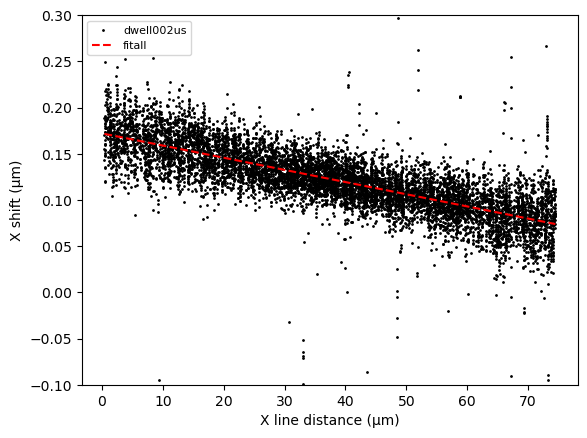

In [20]:
### FIT ALL DATAPOINTS IN ONE FIT - IF ALL LINES AGREE SOMEWHAT

if 'bid' in folder:
    x_lim = scanspeeds[0]*t_lim

    p0 = [1, 1]  # initial guess
    #bounds: a=slope, b=offset
    bounds = [(-10, -30), (10, 30)]
    popt, pcov = curve_fit(linear, x_use_all, y_shift_use_all, p0, bounds=bounds, method='dogbox', maxfev=3000)
    shift_fit = linear(x_fit, *popt)
    axs[0].plot(x_fit, shift_fit, 'k--')

    linfunc_fit = linear(x_fit, *popt)

    plt.scatter(x_all, y_shift_all, s=1, color='k', label=filelist_tif[img_id].split('-')[2].split('.')[0])
    plt.plot(x_fit, linfunc_fit, 'r--', label='fitall')

    plt.ylim([-0.1,0.3])
    plt.legend(prop={'size': 8})
    plt.xlabel('X line distance (µm)')
    plt.ylabel('X shift (µm)')
else:
    x_lim = scanspeeds[0]*t_lim

    x_use_all_less = x_use_all[x_use_all>5]
    y_shift_use_all_less = y_shift_use_all[x_use_all>5]

    plt.scatter(x_all, y_shift_all, s=1, color='k', label=filelist_tif[img_id].split('-')[2].split('.')[0])

    # FIT SINUSOIDAL
    #fitting params: a=amplitude, x0=phase, f=frequency (osc/µm), b=offset, c=linear slope
    if pxsizes[0]*1000 == 70.0:
        p0 = [(max(y_shift_use_all_less)-min(y_shift_use_all_less))/4, 10, 0.8/(0.3*scanspeeds[img_id]), 0.02, 4000]  # initial guess; spatial freq: know temporal frequency is ~0.3 ms^-1
        bounds = [(0, -20, 0.68/(0.3*scanspeeds[img_id]), 0.01, 2000), ((max(y_shift_use_all)-min(y_shift_use_all))/2*5, 20, 0.9/(0.3*scanspeeds[img_id]), 0.06, 6000)]
    elif pxsizes[0]*1000 == 60.0:
        p0 = [(max(y_shift_use_all_less)-min(y_shift_use_all_less))/4, 0, 0.8/(0.3*scanspeeds[img_id]), (max(y_shift_use_all_less)-(max(y_shift_use_all_less)-min(y_shift_use_all_less))/2)+0.01, 4000]  # initial guess; spatial freq: know temporal frequency is ~0.3 ms^-1
        bounds = [((max(y_shift_use_all)-min(y_shift_use_all))/15, -10, 0.68/(0.3*scanspeeds[img_id]), -0.06, 0), ((max(y_shift_use_all)-min(y_shift_use_all))/2, 10, 0.9/(0.3*scanspeeds[img_id]), 0.06, 6000)]
    #print(p0)
    #print(bounds[0])
    #print(bounds[1])
    popt, pcov = curve_fit(sinusoidal, x_use_all_less, y_shift_use_all_less, p0, bounds=bounds, method='dogbox')
    shift_fit = sinusoidal(x_fit, *popt)
    plt.plot(x_fit, shift_fit, 'r--', label='fitall')
    print(popt)

    # FOR PXS 70 NM
    if pxsizes[0]*1000 == 70.0:
        if 'bid' in folder:
            fitfile = 'C:\\Users\\alvelidjonatan\\Documents\\Data\\etMINFLUX-lab\\beads-overlay\\confshift\\final_fits\\multifitting-yshift-pxs70-bid80.txt'
        else:
            fitfile = 'C:\\Users\\alvelidjonatan\\Documents\\Data\\etMINFLUX-lab\\beads-overlay\\confshift\\final_fits\\multifitting-yshift-pxs70-80.txt'
    elif  pxsizes[0]*1000 == 100.0:
        if 'bid' in folder:
            fitfile = 'C:\\Users\\alvelidjonatan\\Documents\\Data\\etMINFLUX-lab\\beads-overlay\\confshift\\final_fits\\multifitting-yshift-pxs100-bid80.txt'
    # FOR PXS 60 NM
    elif pxsizes[0]*1000 == 60.0:
        fitfile = 'C:\\Users\\alvelidjonatan\\Documents\\Data\\etMINFLUX-lab\\beads-overlay\\confshift\\final_fits\\multifitting-yshift-pxs60-40.txt'
        
    with open(fitfile, 'r') as f:
        content = f.read()
    if 'bid' in folder:
        coeffs_lin = coeffs
        combfunc_fit = linear(x_fit, *coeffs_lin)
    else:
        coeffs_sine = [float(i) for i in content.split('\n') if i != '']
        combfunc_fit = sinusoidal(x_fit, *coeffs_sine)
    plt.plot(x_fit, combfunc_fit, 'b--', label='multifit')

    plt.ylim([-0.2,0.2])
    plt.legend(prop={'size': 8})
    plt.xlabel('X line distance (µm)')
    plt.ylabel('Y shift (µm)')

if saving:
    savename = 'multiimagefitting-yshift'
    with open(os.path.join(folder,savename+'.txt'), 'w') as f:
        for line in popt:
            f.write(f"{line}\n")

    savename = 'confshift-yshift-multiimagefitting'
    plt.savefig(os.path.join(folder,savename+'.png'), format="png", bbox_inches="tight")